# Predict_Pollution_From_Fire_Attribute_Data 
This notebook combines observed related PM2.5 with the longer time series of data available on wildfire attributes near Kearney in order to construct a model for smoke impact.


# License
The code in this notebook was developed by Sue Boyd in response to Assignment 1 in DATA 512, a course in the UW MS Data Science degree program. The code in this notebook is provided under the MIT license located in the same repository as this notebook



# Step 0: Prepare Notebook 

In [1]:
# import needed libraries 

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error

# Step 1: Load And Prep Data 

In [2]:
# fire attribute data 1963-2020
f= "Data/fire_dat_merged.csv" 
fires = pd.read_csv(f)
fires.head()

,OID_,Assigned_Fire_Type,Fire_Year,GIS_Acres,Listed_Fire_Names,Listed_Fire_Dates,OBJECTID,Distance to Kearny,Closest long,Closest lat
0,14299,Wildfire,1963,40992.458271,RATTLESNAKE (4),Listed Wildfire Discovery Date(s): 1963-08-06 ...,14299.0,921.876100,-116.526584,44.207390
1,14300,Wildfire,1963,25757.090203,"McChord Butte (2), No Fire Name Provided (1), ...",Listed Wildfire Discovery Date(s): 1963-07-28 ...,14300.0,949.744559,-117.036017,44.470314
2,14301,Wildfire,1963,45527.210986,"WILLOW CREEK (16), EAST CRANE CREEK (4), Crane...",Listed Wildfire Discovery Date(s): 1963-08-06 ...,14301.0,914.071409,-116.333969,44.348362
3,14302,Wildfire,1963,10395.010334,"SOUTH CANYON CREEK (4), No Fire Name Provided (1)",Listed Wildfire Discovery Date(s): 1963-08-06 ...,14302.0,871.999371,-115.702984,43.209292
4,14303,Wildfire,1963,9983.605738,WEBB CREEK (4),Listed Wildfire Discovery Date(s): 1963-08-06 ...,14303.0,911.236425,-116.332136,44.106657


In [3]:
# filter fire attribute data to the years we have pollution estimates (2006-2018)
DATA_YEARS = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
fires_slim = fires[fires["Fire_Year"].isin(DATA_YEARS)]
#fires_slim.head()

In [4]:
# load  and prep historical smoke impact
f = "Data/Annual Summary PM25 Data ODell.csv"
smoke_impact = pd.read_csv(f)
smoke_impact["Tot. Impact"] = smoke_impact["Diff in Mean PM25"]*smoke_impact["Num Smoke Days"]
smoke_impact["Ave. Impact Per Day"] = smoke_impact["Tot. Impact"]/365 
smoke_impact.head()

,Year,Mean PM25 Smoke Days,Mean PM25 Non-Smoke Days,Diff in Mean PM25,Num Smoke Days,Avg. Annual Delta_PM25,Annual Mean Combined,Tot. Impact,Ave. Impact Per Day
0,2006,9.962489,9.129669,0.832820,25.0,0.057042,9.186712,20.820488,0.057042
1,2007,11.532424,10.237317,1.295107,30.0,0.106447,10.343764,38.853217,0.106447
2,2008,13.020036,10.141664,2.878372,40.0,0.315438,10.456240,115.134885,0.315438
3,2009,8.738054,7.630536,1.107518,18.0,0.054617,7.685154,19.935323,0.054617
4,2010,6.578359,7.080457,-0.502098,17.0,-0.023385,7.057071,-8.535658,-0.023385


In [5]:
# Zero out the small negative value for 2010 
smoke_impact.iloc[4,8] = 0
smoke_impact.head()

,Year,Mean PM25 Smoke Days,Mean PM25 Non-Smoke Days,Diff in Mean PM25,Num Smoke Days,Avg. Annual Delta_PM25,Annual Mean Combined,Tot. Impact,Ave. Impact Per Day
0,2006,9.962489,9.129669,0.832820,25.0,0.057042,9.186712,20.820488,0.057042
1,2007,11.532424,10.237317,1.295107,30.0,0.106447,10.343764,38.853217,0.106447
2,2008,13.020036,10.141664,2.878372,40.0,0.315438,10.456240,115.134885,0.315438
3,2009,8.738054,7.630536,1.107518,18.0,0.054617,7.685154,19.935323,0.054617
4,2010,6.578359,7.080457,-0.502098,17.0,-0.023385,7.057071,-8.535658,0.000000


# Step 2: Equations to Estimate Pollution from Fire Attribute Data 

The form of the equation to estimate Raw Smoke impact for an indivual fire will be calculated as: 

   b*(Acres_Burned)^(Size_Factor)*(Distance)^(Distance_Factor)    
   
b is the "discount rate" applied to fires that were a prescribed burn.  It is reasonable to assume that fires that are a perscribed burn contribute less to smoke pollution because they are (one would hope) likely set at times when when wind conditions are more favorable in terms of carrying smoke away from population centers, more often set out of "fire season", and managed for intensity. The default value is set at 0.8 based on research showing that prescribed wildfires do contribute significantly to overall pollution; however more empirical research is required to understand the appropriate discount rate.  In any event, I use the data from observed smoke impacts to help determine this value more precisely. 
 
The smoke impact is assumed to vary linearly with the number of acres burned, thus size_factor has a default value of 1. A linear relationship is a reasonable assumption but could be wrong. For example, perhaps "big" fires are hotter at their center and throw off more smoke per acre? Here again I will use the data to help estimate this parameter.  

The smoke impact is also assumed to vary in inverse proportion to the squared distance from the fire, thus size_factor has a default value of -2. In other words, the further away, the less the smoke impact. The distance in the denominator is squared because the AREA for the smoke to dissipate into is squared as distance increases linearly. Data will also be used to refine this parameter.  

Smoke impact per for the season will be the sum of smoke impact for all fires in that season, multiplied by a factoring constant to scale the results to match the relevant range of PM2.5 estimates.   
 

In [6]:
# set definition of presecribed fire 

per= ['Prescribed Fire', 'Unknown - Likely Prescribed Fire']

In [7]:
# define a function that calculates the impact from an individual fire 

def impact_per_fire(size, distance, prescribed, b, size_fact, dist_fact):
    
    if prescribed:
        x = b
    else: 
        x = 1
    impact = x*(1/(distance**dist_fact))*(size**size_fact)
    return impact

In [8]:
# calculate impact for all fires in the dataset given by df 
# given values of b, size_fact, and dist_fact 
# default value of b is 1 (no discount for prescribed fire)
# default value of size_fact is 1 (pollution linear in size)
# default value of dist_fact is -2 (pollution disapates with the square of the distance)

# Result is a dataframe with columns "Year" and "Impact"


def calc_all_impact(df, b=0.8, size_fact=1, dist_fact=2):
    impact_all = []
    years = []
    for i in range(df.shape[0]):
        row = df.iloc[i]
        year = df.iloc[i]["Fire_Year"]
        acres = row["GIS_Acres"]
        d = row["Distance to Kearny"]
        prescribed = row['Assigned_Fire_Type'] in per
        impact_1 = impact_per_fire(acres, d, prescribed, b, size_fact, dist_fact)    
        impact_all.append(impact_1)
        years.append(year)
        
    impact_df = pd.DataFrame({
        "Year": years,
        "Impact Est. From Attributes": impact_all
    })   
    
        
    return impact_df

In [9]:
# calculate cumulative impact for the season
# result is a dataframe with columns "Year" and "Impact"

def calc_cum_impact(df, b=0.8, size_fact=1, dist_fact=2):
    impact_df = calc_all_impact(df, b, size_fact, dist_fact)
    annual_impact = impact_df.groupby(["Year"])["Impact Est. From Attributes"].sum().reset_index()
    return annual_impact     

As an example, let's calculate annual_imapct on the fires_slim dataset using the default values for the hyperparameters (b = 0.8, sz = 1, d  2) 

In [10]:
# calculate annual_imapct on the fires_slim 
annual_impact = calc_cum_impact(fires_slim)
annual_impact.head()

,Year,Impact Est. From Attributes
0,2006,24.339146
1,2007,18.132912
2,2008,10.957354
3,2009,16.987583
4,2010,7.665874


Now use regression to get the appropriate scale factor to predict pollution.
Changing the scale will not impact the correlation between my estimated PM25 and observed PM25 just will align scale. 
First define the function, then run it on the annual_impact results 

In [11]:
# Function to regress the Impact Estimate from Attributes (df) against the O'Dell data impact estimates 
# W/no intercept to get a scaling factor to put impact onto same scale as PM25 estimates 
# Returns a dataframe with columns "Year" and "Scaled Impact from Attributes"

def calc_scale_and_R2 (df, remove = False):

    # The supervising variable is the annual PM25 estimates from O'Dell 
    if remove: 
        df2 = smoke_impact[smoke_impact["Year"] != 2013]
    else: 
        df2 = smoke_impact
    y = df2["Tot. Impact"]
    
    
    # Predictor variable is the Impact Estimates from the Attributes 
    x = df["Impact Est. From Attributes"]
    X = pd.DataFrame({"Attributes Impact": x}) 

    #build multiple linear regression model
    model_OLS = LinearRegression(fit_intercept=False)
    model_OLS.fit(X, y)

    # Coefficients
    coefficients = model_OLS.coef_
    scale_fac = coefficients[0]

    # R-squared score
    r_squared = model_OLS.score(X, y)
    #print("R2 is", r_squared)

    #Scaled Impact 
    scaled_impact = df["Impact Est. From Attributes"]*scale_fac

    # Make predictions using the model
    y_pred = model_OLS.predict(X)
    y_pred
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(y, y_pred)
    
    # check y_pred should equal scaled impact
    #print("Check, this sum should be close to zero: ", sum(scaled_impact - y_pred))
    model_check = round(sum(scaled_impact - y_pred), 2)
    if model_check != 0:
        print("Oops check your model something doesn't look right")
        
        
    # calculate the correlation between scaled_impact score and the observed PM25 values 
    corr = np.corrcoef(scaled_impact, y)[0, 1]
    
    
    return (scaled_impact, scale_fac, r_squared, mse, corr)

In [12]:
# Now run the regression function on annual_impact

impact_all, scale_factor, r_squared, mse, corr = calc_scale_and_R2(annual_impact)

print("Scale Factor is", scale_factor)
print("R_squared is", r_squared)
print("MSE from train dataset is", mse)
print("Correlation between the sclead impact score and observed PM2.5 is", corr)

#impact_all.head()



Scale Factor is 2.730742388559699
R_squared is -0.39964617518232903
MSE from train dataset is 8783.754038321516
Correlation between the sclead impact score and observed PM2.5 is -0.009821255132180724


Well if we think the O'Dell smoke impact data is close to ground truth, my smoke impact model from the Common Analysis is quite bad! My smoke impacts are actually NEGATIVELY correlated with observed PM2.5 values.  Let's see if it gets better with different values for my hyper parameters. 

# Step 3: Use O'Dell data to select hyper-parameters

First, set a range of hyperparameters to test 

In [13]:
# hyperparams possible values 

b_vals = [0, 0.4, 0.8, 1]
size_facts = [0, 0.5, 1, 1.5, 2]
dist_facts = [0, 1, 2, 2.5, 3]
tot_combos = len(b_vals)*len(size_facts)*len(dist_facts)

Now run through the analysis for each hyperparameter combo and record the results 

In [14]:

# variables to store results 
b_record = []
sz_record = []
d_record = []
r_sq_record = []
mse_record = []
corr_record = []
scale_factor_record = []
i = 0


# run through analysis with each parameter combo and record correlations achieved 
for b in b_vals: 
    for sz in size_facts:
        for d in dist_facts: 
            i += 1
            if i % 10 == 0:
                print(f"On iteration_{i} of_{tot_combos}")
            annual_impact = calc_cum_impact(fires_slim, b, sz, d)
            impact_all, scale_factor, r_squared, mse, corr = calc_scale_and_R2(annual_impact)
            b_record.append(b)
            sz_record.append(sz)
            d_record.append(d)
            r_sq_record.append(r_squared)
            mse_record.append(mse)
            corr_record.append(corr)
            scale_factor_record.append(scale_factor)
            

results = pd.DataFrame({
    "b value": b_record,
    "size factor": sz_record,
    "distance factors": d_record,
    "r_squared": r_sq_record,
    "mse": mse_record,
    "corr": corr_record, 
    "scale_factor": scale_factor_record
    
})            
            
results.head()             


On iteration_10 of_100
On iteration_20 of_100
On iteration_30 of_100
On iteration_40 of_100
On iteration_50 of_100
On iteration_60 of_100
On iteration_70 of_100
On iteration_80 of_100
On iteration_90 of_100
On iteration_100 of_100


,b value,size factor,distance factors,r_squared,mse,corr,scale_factor
0,0.0,0.0,0.0,-0.226505,7697.173555,-0.146647,4.367691e-02
1,0.0,0.0,1.0,-0.267101,7951.939129,-0.133895,2.917201e+01
2,0.0,0.0,2.0,-0.129919,7091.029206,0.077336,1.551636e+04
3,0.0,0.0,2.5,-0.021551,6410.941164,0.335144,2.425465e+05
4,0.0,0.0,3.0,-0.402541,8801.918957,0.393182,1.623800e+06


Find the hyperparameters that resulted in the best correlation

In [15]:
# Find the index of the maximum value in the 'corr' column
max_corr = results['corr'].idxmax()

# Extract the entire row with the maximum 'r_squared' value
row = results.loc[max_corr]
b_final = row["b value"]
sz_final = row["size factor"]
d_final = row["distance factors"]
scale_final = row["scale_factor"]

# Print or use the extracted row as needed
print(row)

b value                  1.000000
size factor              0.000000
distance factors         3.000000
r_squared               -0.288433
mse                   8085.814073
corr                     0.432595
scale_factor        947057.420551
Name: 79, dtype: float64


Even the "best" correlation is not so great, and the "optimal" parameters chosen seem to be devoid of any theoretical justification, making me skeptical that this modelling approach is worth pursuing.  Still, let's calculate and graph the smoke impact estimates and see how they look.

# Step 4 - Using selected hyper-parameters, calculate fire impact all years 1980+

In [16]:
# set hyperparams to values selected above
b = b_final
sz = sz_final
d = d_final
scale = scale_final

In [17]:
# caclulate fire impact for all years > 1979 from attribute data
# Use 1980+ because fires are underestimated in earlier years 
fires_1980 = fires[fires["Fire_Year"] > 1979]
annual_impact_1980 = calc_cum_impact(fires_1980, b, sz, d)
annual_impact_1980["Scaled Impact"] = annual_impact_1980["Impact Est. From Attributes"]*scale
annual_impact_1980["Ave Impact Per Day"] = annual_impact_1980["Scaled Impact"]/365
annual_impact_1980.head()

,Year,Impact Est. From Attributes,Scaled Impact,Ave Impact Per Day
0,1980,0.000004,3.811407,0.010442
1,1981,0.000002,1.866545,0.005114
2,1982,0.000002,1.476069,0.004044
3,1983,0.000002,2.043622,0.005599
4,1984,0.000004,3.906535,0.010703


In [18]:
# display last few years of results for inspection 
annual_impact_1980.tail()

,Year,Impact Est. From Attributes,Scaled Impact,Ave Impact Per Day
36,2016,0.000064,60.864916,0.166753
37,2017,0.000053,49.960034,0.136877
38,2018,0.000291,275.266319,0.754154
39,2019,0.000683,646.425867,1.771030
40,2020,0.000034,31.989149,0.087642


R-squared value: 0.20093920477468497


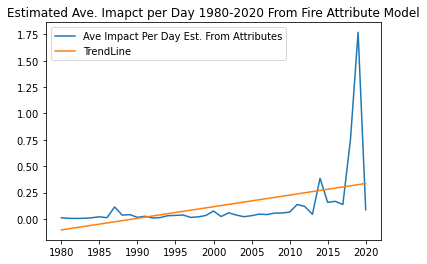

In [20]:
# graph results 
x = annual_impact_1980["Year"]
y = annual_impact_1980["Ave Impact Per Day"]
plt.plot(x, y, label = "Ave Impact Per Day Est. From Attributes")
t = "Estimated Ave. Imapct per Day 1980-2020 From Fire Attribute Model"
plt.title(t)

         
# Add a trendline 
x2 = np.ones(len(x))
X = pd.DataFrame({"Year": x, "Constant": x2})  
model_OLS = LinearRegression()
model_OLS.fit(X, y)
y_pred = model_OLS.predict(X)   
plt.plot(x, y_pred, label = "TrendLine")
plt.title(t)
         
    
r2_value = model_OLS.score(X, y)
print(f"R-squared value: {r2_value}")    
         
plt.legend()         
plt.show();       
         

# OBSERVATION / DISCUSSION 

Even the best correlation between my model from fire attributes and the observed PM 25 levels aren't great.  Also, the hyperparameters selected don't seem to have much justification.  Finally, if I did use the attribute model to predict future P2.5 levels, the linear regression model has an R2 of only .2 which is very low for future prediction even assuming - which is HIGHLY unlikely - that the constructed PM25 estiamte are good ones.    

In short, there is more noise than signal here, so I will stick with using just observed PM2.5 levels to predict future health impact.  


# That's a Wrap! 